In [13]:
rates = list(range(10, 121, 10))
rates

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
def read_data(rate) -> pd.DataFrame:
    # print(rate)
    df = pd.read_csv(f"../continuous{rate}.csv")
    df["full_duration"] = df["draw_end_time"] - df["start_time"]
    df["sleep_duration"] = df["tick_time"] - df["start_time"]
    df["logic_duration"] = df["before_draw_time"] - df["tick_time"]
    df["draw_duration"] = df["draw_end_time"] - df["before_draw_time"]
    df["start_cycle"] = df["start_time"].diff()
    df = df.iloc[50:-50] # clean up a bit
    return df

In [15]:
mean_df = pd.DataFrame(index=rates, columns=["start_cycle", "full_duration", "delay", "sleep_duration", "logic_duration", "draw_duration"])
all_dfs = {}
for rate in rates:
    rate_df = read_data(rate)
    mean_df.loc[rate] = rate_df[mean_df.columns].mean()
    all_dfs[rate] = rate_df
    
mean_df["target_time"] = 1.0 / mean_df.index
mean_df["overslept"] = mean_df["sleep_duration"] - mean_df["delay"]
mean_df["unaccounted"] = mean_df["start_cycle"] - mean_df["full_duration"] # time outside the draw loop
mean_df
# mean_df.mul(-1)

,start_cycle,full_duration,delay,sleep_duration,logic_duration,draw_duration,target_time,overslept,unaccounted
10,0.100642,0.100633,0.099115,0.099758,0.000112,0.000763,0.100000,0.000642,0.00001
20,0.051522,0.051514,0.049172,0.050694,0.000109,0.00071,0.050000,0.001523,0.000009
30,0.03454,0.034531,0.03252,0.033726,0.000107,0.000698,0.033333,0.001206,0.000009
40,0.028676,0.028672,0.024201,0.027883,0.000101,0.000688,0.025000,0.003682,0.000004
50,0.020991,0.020983,0.019205,0.020196,0.000106,0.00068,0.020000,0.000991,0.000009
60,0.016999,0.01699,0.015884,0.016216,0.000105,0.000669,0.016667,0.000332,0.000008
70,0.015032,0.015023,0.013507,0.014253,0.000104,0.000666,0.014286,0.000746,0.000008
80,0.013051,0.013042,0.011713,0.012264,0.000106,0.000672,0.012500,0.000551,0.000009
90,0.012021,0.012012,0.010322,0.011232,0.000107,0.000674,0.011111,0.00091,0.000009
100,0.011005,0.010996,0.009221,0.010225,0.000103,0.000668,0.010000,0.001005,0.000008


<Axes: >

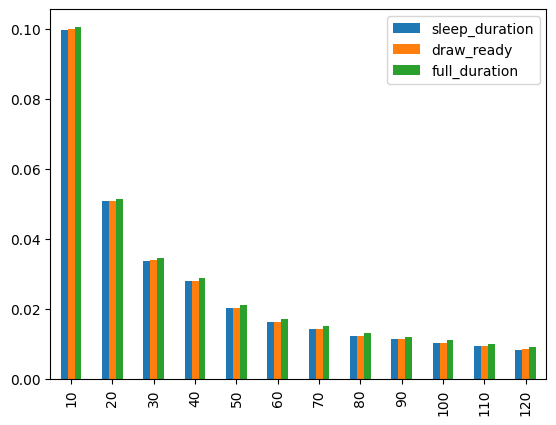

In [16]:
# start -> sleep -> logic -> draw
# start_time, tick_time, before_draw_time, draw_end_time
# start_cycle, (delay), sleep_duration, draw_ready (sleep_duration + logic_duration), full_duration
mean_df["draw_ready"] = mean_df["sleep_duration"] + mean_df["logic_duration"]
mean_df[["sleep_duration", "draw_ready", "full_duration"]].plot.bar(stacked=False)

In [17]:
# bad normalization :/
# mean_df = mean_df.div(mean_df["target_time"], axis=0)
# mean_df = mean_df.subtract(mean_df["target_time"], axis=0)
# mean_df

<Axes: >

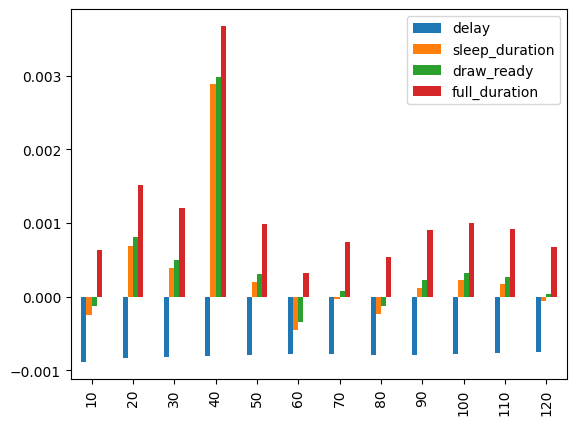

In [18]:
# so the target is about at 0, want to see how much time the sleep left us for "logic"+ draw
# vs how much it actually slept and then the draw took
# TODO: get the relative values so this can become a stacked plot again.
# likely need to measure the cycles from the top.
mean_df[["delay", "sleep_duration", "draw_ready", "full_duration"]].subtract(mean_df["target_time"], axis=0).plot.bar(stacked=False)

In [19]:
# relative? # TODO: needs subtract again -.- seems likea circular math at one point.
mean_df["oversleep"] = mean_df["sleep_duration"] - mean_df["delay"]

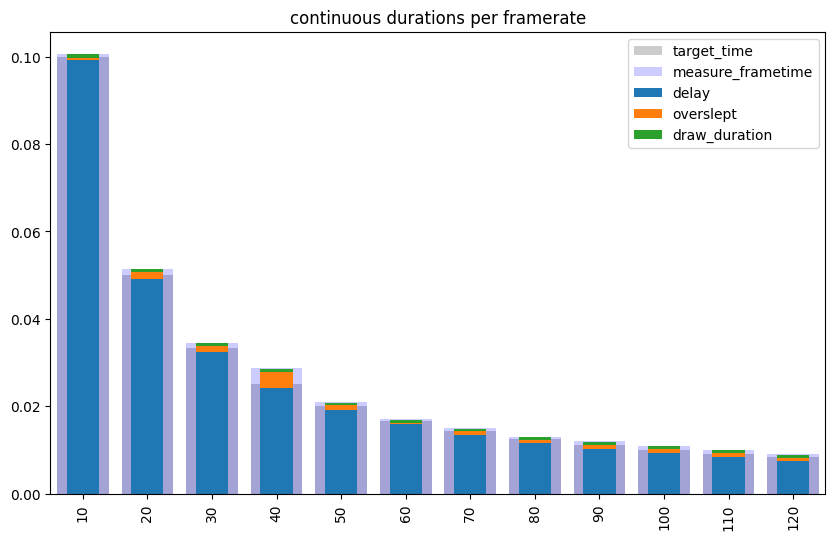

In [20]:
# this Y scale is awful as you can't really tell or compare. Maybe I can get the sleep/delay into the negative direction
# since you might want to compare the overslept and draw durations, so they should be nearly lined up.

fig = plt.figure(figsize=(10, 6))
ax = plt.gca()
plt.bar(x=range(len(mean_df.index)), height=mean_df["target_time"], label="target_time", color="k", alpha=0.2)
plt.bar(x=range(len(mean_df.index)), height=mean_df["start_cycle"], label="measure_frametime", color="b", alpha=0.2)
mean_df[["delay", "overslept", "draw_duration"]].plot.bar(stacked=True, ax=ax, alpha=1.0,)
# mean_df["expected_rate"].plot.bar(label="expected_rate", ax=plt.gca(), color="k", linestyle="--", alpha=0.2)
# ax.yaxis.set_inverted(True)
plt.title("continuous durations per framerate")
plt.legend()

# mean_df["draw_duration"].div(mean_df["expected_rate"]).plot(label="sleep_duration")

In [21]:
# earlier plotting code, not working anymore
fig = plt.figure(figsize=(20, 5))
plt.axhline(expected_frame_time, color="red", label="expected frame time")
# plt.bar(df.index, df["full_duration"], label="full duration", width=1.0, alpha=0.5)
df["full_duration"].plot(kind="bar", width=1.0, alpha=0.9, label="full duration")
df[["sleep_duration", "draw_duration"]].plot(kind="bar", stacked=True, ax=plt.gca(), width=1.0, alpha=0.5)
df["delay"].plot(kind="bar", width=1.0, alpha=0.7, color="green", legend=False)
plt.xticks([])
# plt.plot(df["full_duration"], label="full duration")
# plt.plot(df["draw_duration"], label="draw duration")
# plt.plot(df["delay"])
# plt.plot(df["sleep_duration"])
plt.show()

NameError: name 'expected_frame_time' is not defined

<Figure size 2000x500 with 0 Axes>

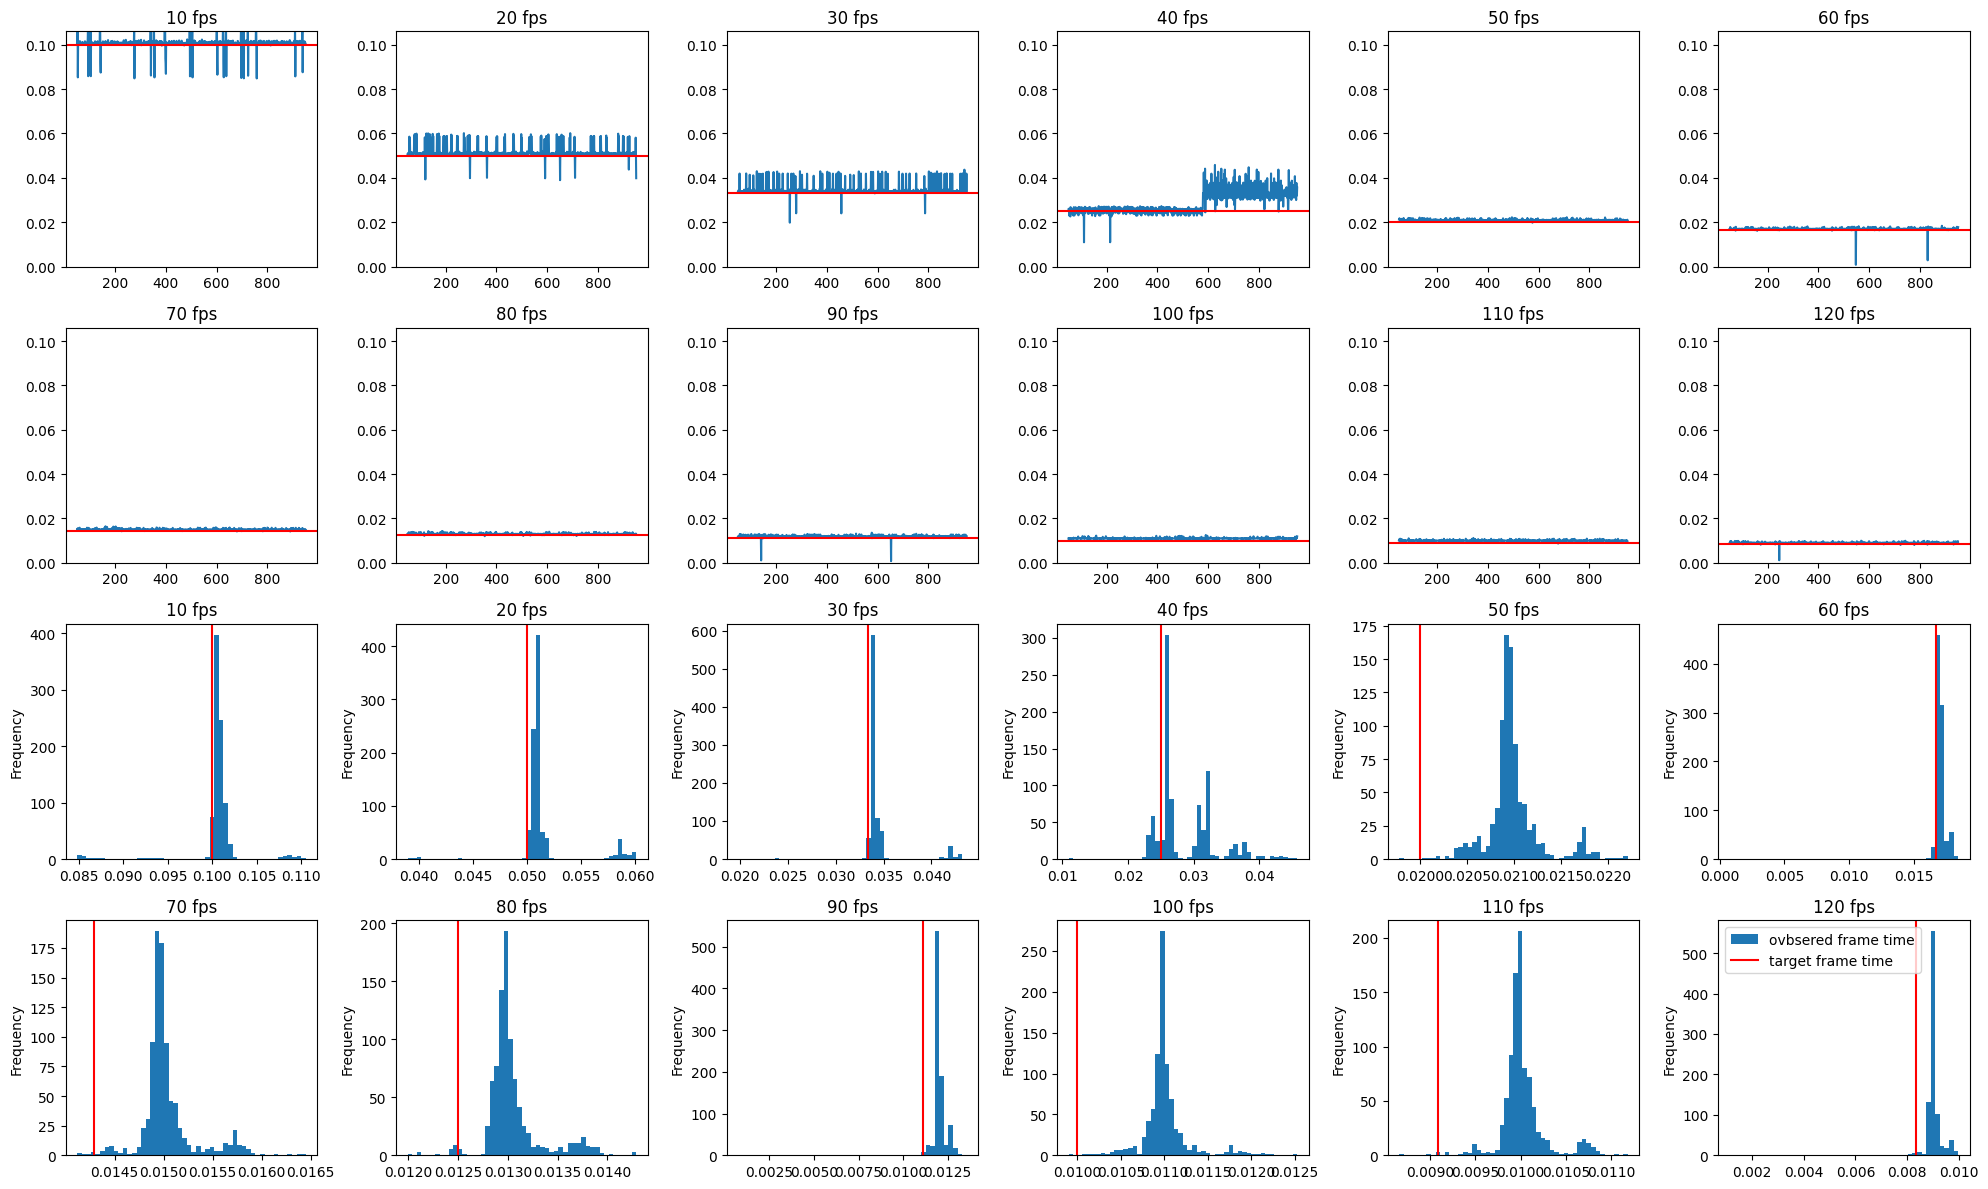

In [86]:
fig, axs = plt.subplots(4, 6, figsize=(20, 12))
axes = axs.flatten()
refresh_rate = 1.0 / 165.0

for idx, (rate, df) in enumerate(all_dfs.items()):
    line_ax = axes[idx]
    hist_ax = axes[idx + 12]
    expected_frametime = 1.0 / rate
    # line
    df["start_cycle"].plot(ax=line_ax, title=f"{rate} fps", label="observed frame time")
    line_ax.axhline(expected_frametime, color="red")
    line_ax.set_ylim(0, 0.1 + refresh_rate)

    # hist
    df["start_cycle"].plot.hist(bins=50, ax=hist_ax, title=f"{rate} fps", label="ovbsered frame time")
    hist_ax.axvline(expected_frametime, color="red", label="target frame time")
    # hist_ax.set_xlim(expected_frametime - refresh_rate, expected_frametime + refresh_rate)

    # rate_ax.axhline(expected_frametime + refresh_rate, color="green", linestyle="--")
plt.tight_layout()
plt.legend()
plt.show()